# Section 09 - Probe Delivery

## Initial Capture Orbit

In [ ]:
import numpy as np

from AMAT.planet import Planet
from AMAT.vehicle import Vehicle
from AMAT.approach import Approach
from AMAT.orbiter import Orbiter

## Compute the approach trajectory

In [2]:
probe1 = Approach("URANUS",
                  v_inf_vec_icrf_kms=np.array([-9.62521831, 16.51192666, 7.46493598]),
                  rp=(25559 + 345) * 1e3, psi=np.pi,
                  is_entrySystem=True, h_EI=1000e3)

theta_star_arr_probe1 = np.linspace(-1.8, probe1.theta_star_entry, 101)
pos_vec_bi_arr_probe1 = probe1.pos_vec_bi(theta_star_arr_probe1) / 25559e3

x_arr_probe1 = pos_vec_bi_arr_probe1[0][:]
y_arr_probe1 = pos_vec_bi_arr_probe1[1][:]
z_arr_probe1 = pos_vec_bi_arr_probe1[2][:]

## Compute the aerocapture corridor

In [3]:
# setup the Planet object
planet=Planet("URANUS")
planet.h_skip = 1000e3
planet.loadAtmosphereModel('../../../atmdata/Uranus/uranus-gram-avg.dat', 0 , 1 ,2, 3, heightInKmFlag=True)
planet.h_low = 120e3
planet.h_trap= 100e3

# Setup the vehicle object : assume m=3000 kg, beta=200 kg/m2
vehicle=Vehicle('Titania', 3200.0, 146 , 0.24, np.pi*4.5**2.0, 0.0, 1.125, planet)
vehicle.setInitialState(1000.0,-15.22,75.55,29.2877,88.687,-11.0 ,0.0,0.0)
vehicle.setSolverParams(1E-6)

# Compute the corridor bounds and TCW
overShootLimit, exitflag_os  = vehicle.findOverShootLimit2(2400.0,0.1,-25,-4.0,1E-10,500e3)
underShootLimit, exitflag_us  = vehicle.findUnderShootLimit2(2400.0,0.1,-25 ,-4.0,1E-10,500e3)

# print the overshoot and undershoot limits we just computed.
print("Overshoot  limit : "+str('{:.4f}'.format(overShootLimit))+ " deg")
print("Undershoot limit : "+str('{:.4f}'.format(underShootLimit))+ " deg")
print("TCW: "+ str('{:.4f}'.format(overShootLimit-underShootLimit))+ " deg")

Overshoot  limit : -11.0088 deg
Undershoot limit : -12.0264 deg
TCW: 1.0176 deg


## Get a propagated vehicle object with an exit state

In [4]:
# propogate the overshoot trajectory
vehicle.setInitialState(1000.0,-15.22,75.55,29.2877,88.687,overShootLimit,0.0,0.0)
vehicle.propogateEntry2(2400.0,0.1,180.0)

## Compute the coast phase trajectory, PRM dv, and full orbit trajectory

In [5]:
orbiter = Orbiter(vehicle, peri_alt_km=4000.0)

# print the periapsis raise manuever DV
print("PRM DV VEC, m/s: "+str(orbiter.PRM_dv_vec))
print("PRM DV MAG, m/s: "+str(orbiter.PRM_dv_mag))

PRM DV VEC, m/s: [ 64.07245044 -12.31975871   8.76878289]
PRM DV MAG, m/s: 65.83271916788875


Run the file ```example-09-initial-orbit.py``` for a visualization of the hyperbolic approach, coast phase and the final orbit trajectory.

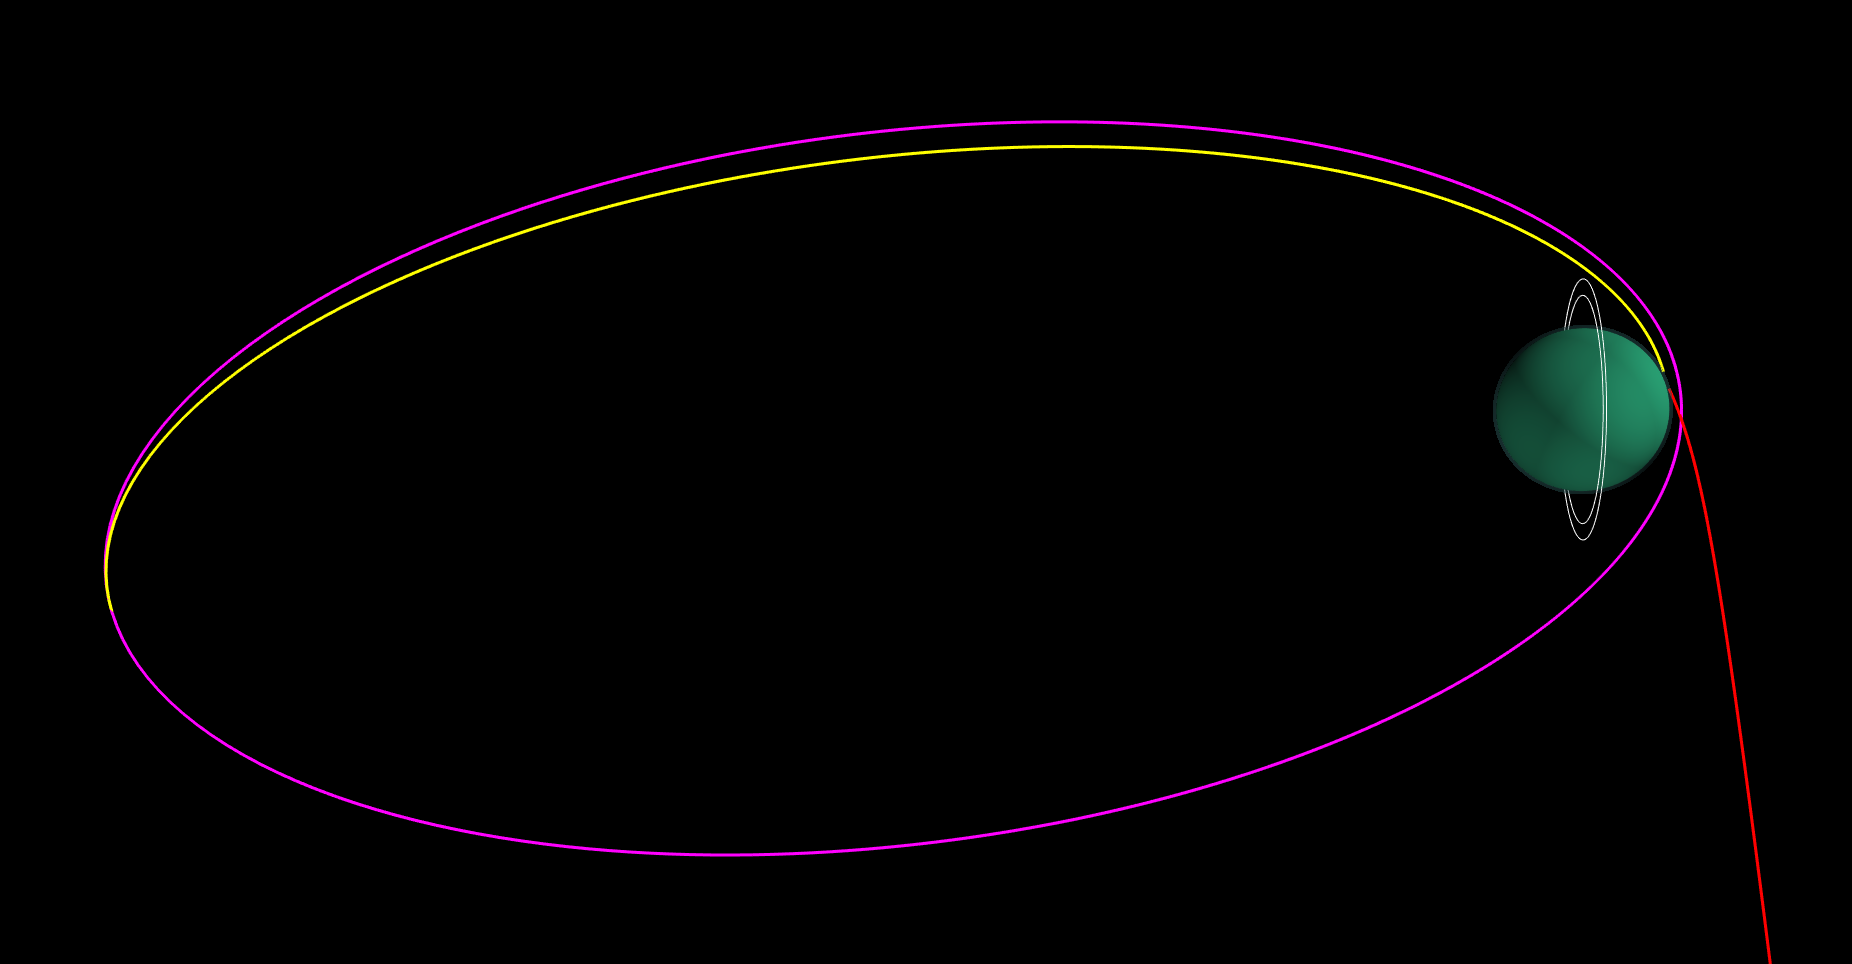

In [6]:
from IPython.display import Image
Image(filename="../../../data/acta-astronautica/uranus-orbiter-probe/initial-orbit.png", width=1200)

In [21]:
def compute_TOF(a, e, GM, theta_star_1, theta_star_2):
    
    """
    Computes the TOF between two true anomalies
    """
    
    # Compute E1
    if theta_star_1 >= 0 and theta_star_1 <= np.pi:
        E1 = 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(theta_star_1/2))
    else:
        E1 = 2*np.pi - 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(theta_star_1/2))
        
    # Compute E2
    if theta_star_2 >= 0 and theta_star_2 <= np.pi:
        E2 = 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(theta_star_2/2))
    else:
        E2 = 2*np.pi - 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(theta_star_2/2))
    
    
    # Compute TOF
    TOF = np.sqrt(a**3/GM)*(E2 - E1 + e*(np.sin(E1) - np.sin(E2)))
    return TOF

In [24]:
def compute_TOF(a, e, GM, theta_star_1, theta_star_2):
    
    """
    Computes the TOF between two true anomalies
    """
    
    # Compute E1
    E1 = 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(theta_star_1/2))
    if E1 < 0:
        E1 = 2*np.pi + E1
        
    # Compute E2
    E2 = 2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(theta_star_2/2))
    if E2 < 0:
        E2 = 2*np.pi + E2
        
    
    # Compute TOF
    TOF = np.sqrt(a**3/GM)*(E2 - E1 + e*(np.sin(E1) - np.sin(E2)))
    return TOF

In [35]:
compute_TOF(a=orbiter.a, 
            e=orbiter.e, 
            GM=planet.GM, 
            theta_star_1=178*np.pi/180, 
            theta_star_2=182*np.pi/180)/(60*60)

9.374267720748781

## Perform a probe-targeting maneuver

Perform a probe targeting manuever at theta_star = 178 deg, dV = -90 m/s

In [51]:
orbiter.compute_probe_targeting_trajectory(178 * np.pi / 180, -90)

In [52]:
# print the probe targeting manuever orbit periapsis altitude
print("Probe approach orbit periapsis alt. km : "+str(orbiter.h_periapsis_probe/1e3))

Probe approach orbit periapsis alt. km : -716.3110821775309


In [53]:
# print the probe atmospheric entry state
print("Entry altitude, km: "+ str(orbiter.h_EI/1e3))
print("Entry longitude BI, km: "+ str(round(orbiter.longitude_probe_entry_bi*180/np.pi, 2)))
print("Entry latitude BI, deg: "+ str(round(orbiter.latitude_probe_entry_bi*180/np.pi, 2)))
print("Atm. relative entry speed, km/s: "+str(round(orbiter.v_mag_probe_entry_atm/1e3, 4)))
print("Atm. relative heading angle, deg: "+str(round(orbiter.heading_atm_probe_entry*180/np.pi, 4)))
print("Atm. relative EFPA, deg: "+str(round(orbiter.gamma_atm_probe_entry*180/np.pi, 4)))

Entry altitude, km: 1000.0
Entry longitude BI, km: -10.96
Entry latitude BI, deg: 67.49
Atm. relative entry speed, km/s: 20.4018
Atm. relative heading angle, deg: 87.1923
Atm. relative EFPA, deg: -14.0304


## Perform an orbiter deflection manuever

Perform an orbiter deflection manuever at theta_star = 182 deg, dV = +75 m/s

In [70]:
orbiter.compute_orbiter_deflection_trajectory(182 * np.pi / 180, 89.38)

In [71]:
# print the orbiter deflection orbit periapsis altitude
print("Orbiter deflection orbit periapsis alt. km : "+str(orbiter.h_periapsis_orbiter_defl/1e3))

Orbiter deflection orbit periapsis alt. km : 4000.758188017596


## Compute probe entry trajectory

In [78]:
planet.h_trap= -100e3

In [100]:
# Set up the entry probe vehicle
vehicle1=Vehicle('uranus-probe', 300.0, 172.0, 0.0, np.pi*1.26**2.0*0.25, 0.0, 0.40, planet)
# Set up entry parameters
vehicle1.setInitialState(1000.0, -10.96, 67.49, 20.4018, 87.1923, -14.0304, 0.0, 0.0)
# Set up solver
vehicle1.setSolverParams(1E-6)
# Propogate vehicle entry trajectory
vehicle1.propogateEntry (10*60.0,0.1,0.0)

In [101]:
# import rcParams to set figure font type
import matplotlib.pyplot as plt
from matplotlib import rcParams

<Figure size 640x480 with 0 Axes>

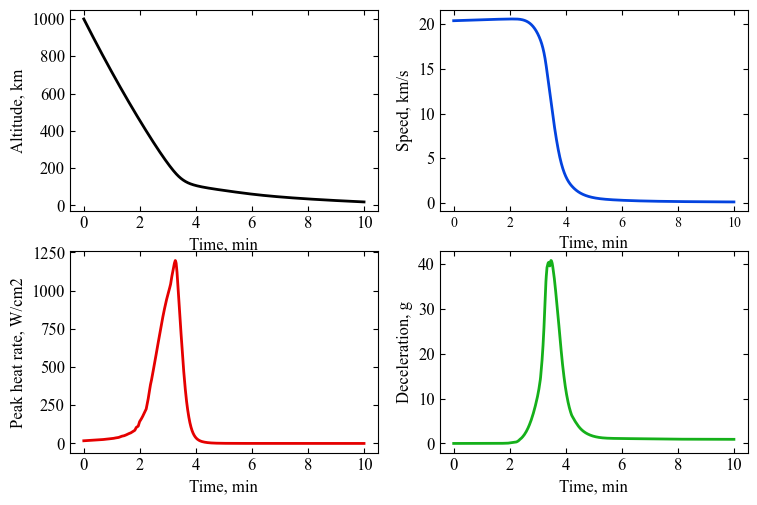

In [110]:
# plot overshoot and undershoot trajectories
fig = plt.figure()
fig = plt.figure()
fig.set_size_inches([8.75,5.75])
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)


plt.subplot(2, 2, 1)
plt.plot(vehicle1.t_minc , vehicle1.h_kmc, linestyle='solid' , color='xkcd:black',linewidth=2.0)
plt.xlabel('Time, min',fontsize=12)
plt.ylabel("Altitude, km",fontsize=12)
ax = plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.tick_params(direction='in')
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)

plt.subplot(2, 2, 2)
plt.plot(vehicle1.t_minc , vehicle1.v_kmsc , linestyle='solid' , color='xkcd:blue',linewidth=2.0)

plt.xlabel('Time, min',fontsize=12)
plt.ylabel("Speed, km/s",fontsize=12)
ax = plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.tick_params(direction='in')
plt.tick_params(axis='x',labelsize=10)
plt.tick_params(axis='y',labelsize=12)

plt.subplot(2, 2, 3)
plt.plot(vehicle1.t_minc , vehicle1.q_stag_total, linestyle='solid' , color='xkcd:red',linewidth=2.0)
plt.xlabel('Time, min',fontsize=12)
plt.ylabel("Peak heat rate, W/cm2",fontsize=12)
ax = plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.tick_params(direction='in')
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)

plt.subplot(2, 2, 4)
plt.plot(vehicle1.t_minc , vehicle1.acc_net_g , linestyle='solid' , color='xkcd:green',linewidth=2.0)

plt.xlabel('Time, min',fontsize=12)
plt.ylabel("Deceleration, g",fontsize=12)
ax = plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.tick_params(direction='in')
plt.tick_params(axis='x',labelsize=12)
plt.tick_params(axis='y',labelsize=12)





plt.savefig('../../../data/acta-astronautica/uranus-orbiter-probe/probe-entry-trajectory.png', dpi= 300,bbox_inches='tight')
plt.savefig('../../../data/acta-astronautica/uranus-orbiter-probe/probe-entry-trajectory.pdf', dpi=300,bbox_inches='tight')
plt.savefig('../../../data/acta-astronautica/uranus-orbiter-probe/probe-entry-trajectory.eps', dpi=300,bbox_inches='tight')


plt.show()

Run the file ```example-09-probe-orbiter-trajectory.py``` for a visualization of the hyperbolic approach, coast phase and the final orbit trajectory.

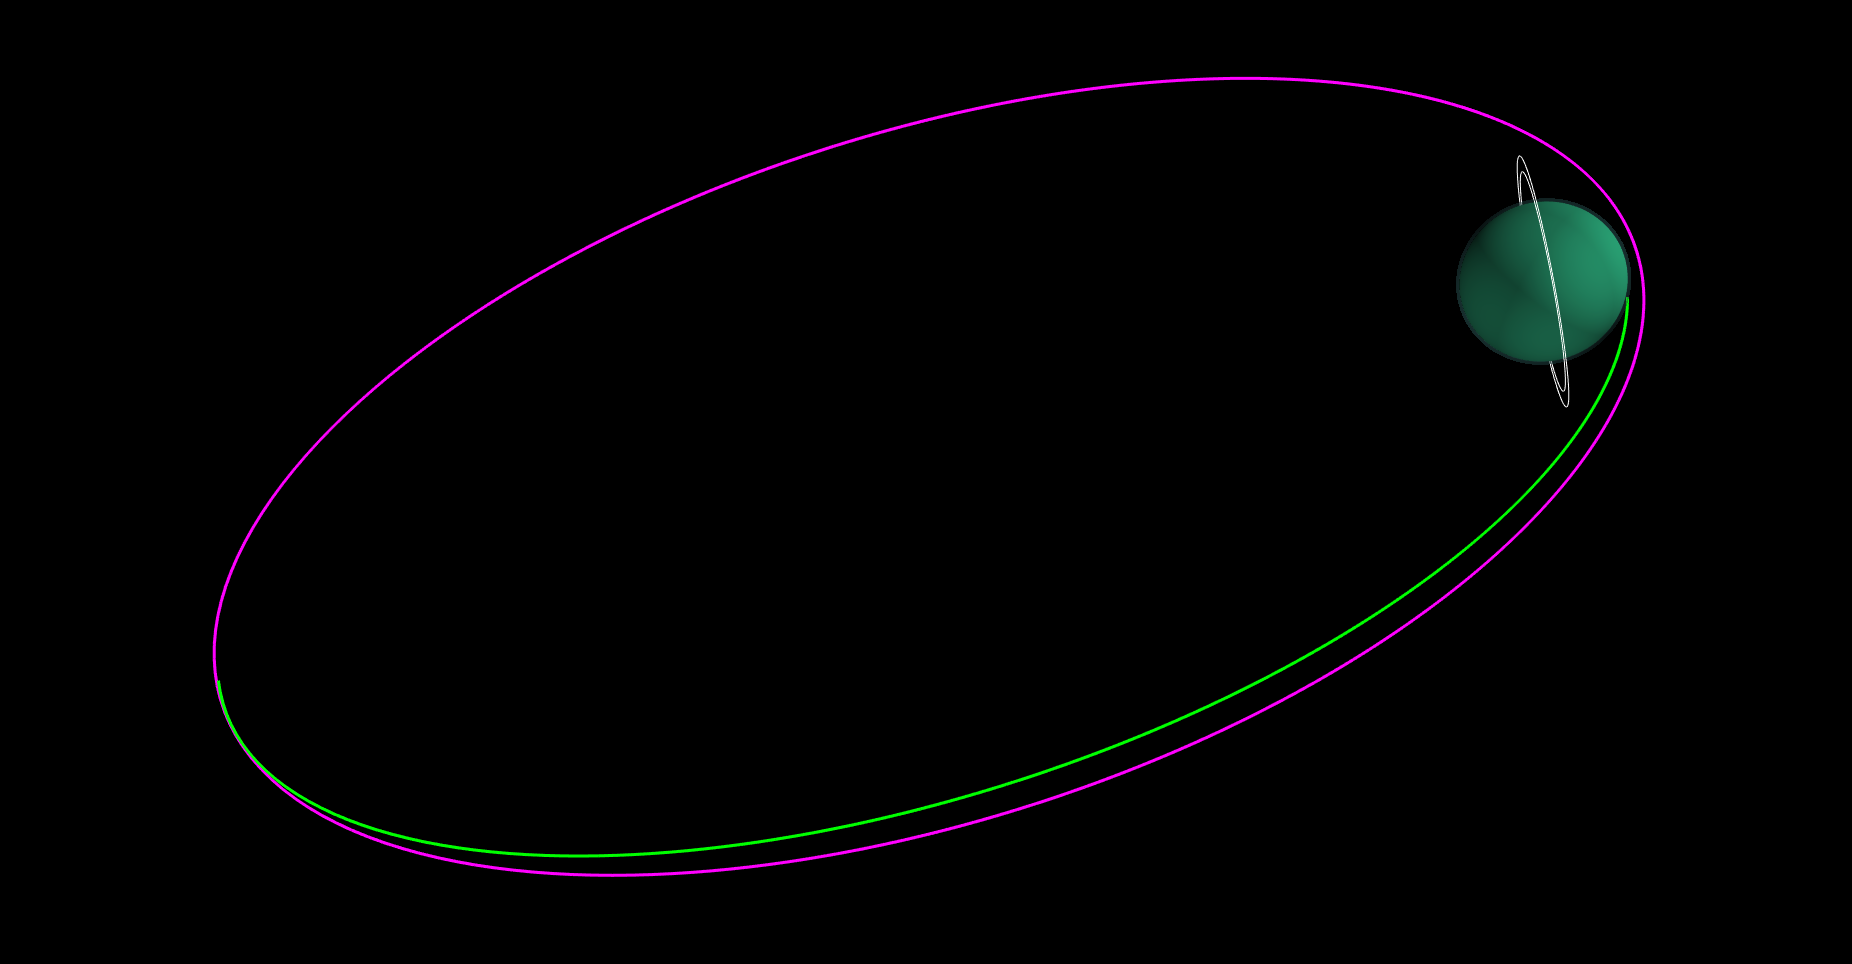

In [106]:
Image(filename="../../../data/acta-astronautica/uranus-orbiter-probe/probe-orbiter-trajectory.png", width=1200)